# Converting eye-tracking into BIDS

blah blah

In [62]:
%matplotlib inline

from pathlib import Path
from json import dumps
import string
import numpy as np
from scipy.signal import fftconvolve
from matplotlib import pyplot as plt
import pandas as pd

from pyedfread import edf, edfread

plt.rcParams["figure.figsize"] = (20, 2.5)

In [63]:
edf_lookup = pd.read_csv("schedule.tsv", sep='\t', na_values="n/a")
edf_lookup

,session,day,PE,dwi_edf,qct_edf,rest_edf,bht_edf
0,1,2023-10-20,LR,fixation_2023-10-20_18h46.06.106_4_session_1.EDF,qct_2023-10-20_19h40.38.964_2_session_1.EDF,rest_2023-10-20_19h48.22.344_0_session_1.EDF,bht_2023-10-20_20h10.50.517_0_session_1.EDF
1,3,2023-10-21,LR,fixation_2023-10-21_09h26.29.983_3_session_3.EDF,qct_2023-10-21_10h04.32.961_0_session_3.EDF,rest_2023-10-21_10h11.23.092_0_session_3.EDF,bht_2023-10-21_10h33.23.269_0_session_3.EDF
2,4,2023-10-21,RL,fixation_2023-10-21_11h28.03.360_2_session_4.EDF,qct_2023-10-21_12h14.11.346_3_session_4.EDF,rest_2023-10-21_12h20.30.939_0_session_4.EDF,bht_2023-10-21_12h43.24.654_0_session_4.EDF
3,5,2023-10-22,PA,fixation_2023-10-22_09h46.25.719_2_session_5.EDF,qct_2023-10-22_10h25.10.141_0_session_5.EDF,rest_2023-10-22_10h32.38.153_0_session_5.EDF,bht_2023-10-22_10h55.36.134_0_session_5.EDF
4,6,2023-10-22,PA,fixation_2023-10-22_11h32.03.586_0_session_6.EDF,qct_2023-10-22_12h10.47.134_0_session_6.EDF,rest_2023-10-22_12h16.56.202_0_session_6.EDF,bht_2023-10-22_12h38.49.185_0_session_6.EDF
5,7,2023-10-23,LR,fixation_2023-10-23_19h44.11.104_2_session_7.EDF,qct_2023-10-23_20h25.20.999_0_session_7.EDF,rest_2023-10-23_20h31.49.334_0_session_7.EDF,bht_2023-10-23_20h54.11.318_1_session_7.EDF
6,8,2023-10-23,RL,fixation_2023-10-23_21h30.29.785_0_session_8.EDF,qct_2023-10-23_22h08.36.963_0_session_8.EDF,rest_2023-10-23_22h15.00.201_0_session_8.EDF,bht_2023-10-23_22h36.54.314_0_session_8.EDF
7,9,2023-10-24,AP,fixation_2023-10-24_19h28.01.875_1_session_9.EDF,qct_2023-10-24_20h15.40.693_0_session_9.EDF,rest_2023-10-24_20h24.27.482_0_session_9.EDF,bht_2023-10-24_20h46.08.308_0_session_9.EDF
8,10,2023-10-24,RL,fixation_2023-10-24_21h26.14.900_1_session_10.EDF,qct_2023-10-24_22h10.40.236_0_session_10.EDF,rest_2023-10-24_22h18.14.132_0_session_10.EDF,bht_2023-10-24_22h41.05.920_0_session_10.EDF
9,11,2023-10-25,AP,fixation_2023-10-25_20h37.34.053_7_session_11.EDF,qct_2023-10-25_21h12.18.840_0_session_11.EDF,rest_2023-10-25_21h23.26.254_0_session_11.EDF,bht_2023-10-25_21h47.06.131_1_session_11.EDF


In [64]:
DATA_PATH = Path("/data/datasets/hcph-pilot-sourcedata/recordings/psychopy/")
BIDS_PATH = Path("/data/datasets/hcph")

participant = "001"
session = 38

et_session = edf_lookup[edf_lookup.session == session]
pe = et_session.PE.values[0]

In [91]:
samples, events, messages = edf.pread(str(DATA_PATH / et_session.dwi_edf.values[0]), filter=['all'])

In [92]:
samples = samples.reindex(columns=[c for c in samples.columns if "left" not in c])
samples.rename(columns={"time": "eye_timestamp", "gx_right": "eye1_x_coordinate", "gy_right": "eye1_y_coordinate", "pa_right": "eye1_pupil_size", "px_right": "eye1_pupil_x_coordinate", "py_right": "eye1_pupil_y_coordinate"})

,eye_timestamp,eye1_pupil_x_coordinate,eye1_pupil_y_coordinate,hx_right,hy_right,eye1_pupil_size,eye1_x_coordinate,eye1_y_coordinate,rx,ry,...,fgyvel,fhxyvel,fhyvel,frxyvel,fryvel,flags,input,buttons,htype,errors
0,8521569.0,-2129.0,-5949.0,-30.0,363.0,5578.0,396.799988,336.799988,26.5,26.5,...,0.0,4.566832e-41,0.0,0.0,4.566832e-41,32641.0,32768.0,0.0,-32768.0,0.0
1,8521570.0,-2128.0,-5954.0,-29.0,358.0,5590.0,396.899994,336.200012,26.5,26.5,...,0.0,4.566832e-41,0.0,0.0,4.566832e-41,24449.0,32768.0,0.0,-32768.0,0.0
2,8521571.0,-2126.0,-5958.0,-28.0,352.0,5601.0,397.100006,335.700012,26.5,26.5,...,0.0,4.566832e-41,0.0,0.0,4.566832e-41,24449.0,32768.0,0.0,-32768.0,0.0
3,8521572.0,-2123.0,-5957.0,-25.0,353.0,5612.0,397.399994,335.799988,26.5,26.5,...,0.0,4.566832e-41,0.0,0.0,4.566832e-41,24449.0,32768.0,0.0,-32768.0,0.0
4,8521573.0,-2122.0,-5952.0,-24.0,359.0,5608.0,397.500000,336.399994,26.5,26.5,...,0.0,4.566832e-41,0.0,0.0,4.566832e-41,24449.0,32768.0,0.0,-32768.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007887,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2007888,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2007889,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2007890,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0


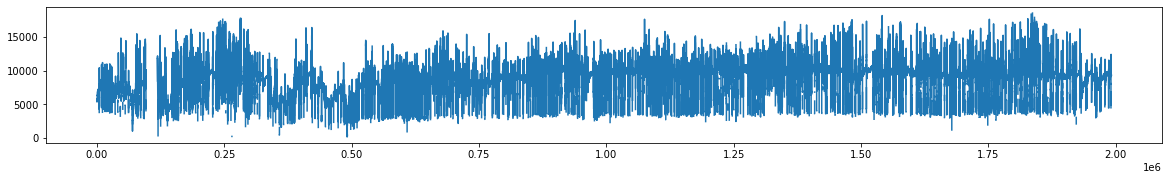

In [93]:
samples.pa_right[samples.pa_right < 1] = np.nan
plt.plot(samples.pa_right)

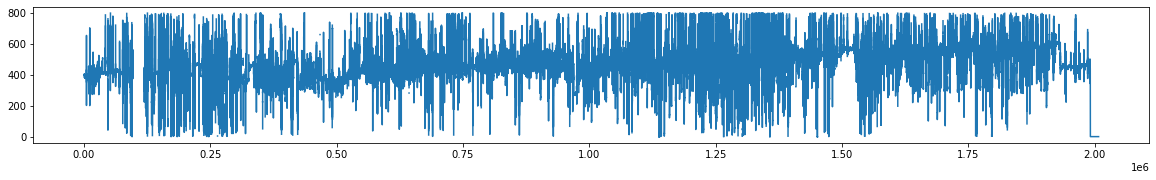

In [94]:
samples.gx_right[(samples.gx_right < 0) | (samples.gx_right > 800)] = np.nan
plt.plot(samples.gx_right)

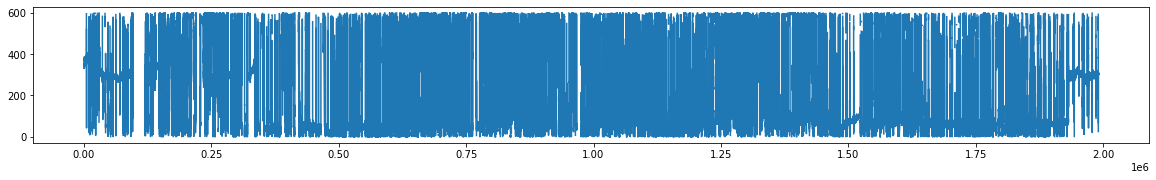

In [95]:
samples.gy_right[(samples.gy_right <= 0) | (samples.gy_right > 600)] = np.nan
plt.plot(samples.gy_right)

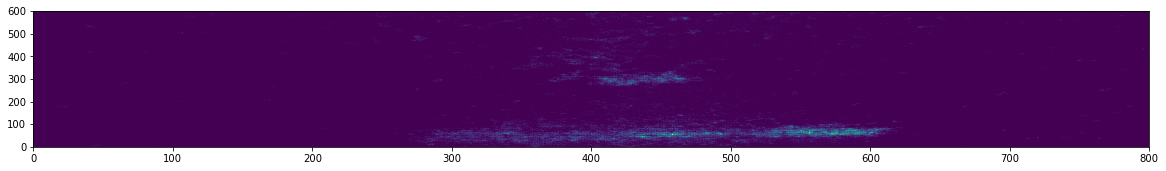

In [96]:
plt.hist2d(samples.gx_right, samples.gy_right, range=[[0, 800], [0, 600]], bins=1000);

In [79]:
samples[samples["htype"].notna()]["htype"]

0        -32768.0
1        -32768.0
2        -32768.0
3        -32768.0
4        -32768.0
           ...   
159126        0.0
159127        0.0
159128        0.0
159129        0.0
159130        0.0
Name: htype, Length: 159131, dtype: float64

In [23]:
message = edfread.read_messages(str(DATA_PATH / et_session.qct_edf.values[0]))
message

[b'DRIFTCORRECT R RIGHT at 400,300  OFFSET 0.82 deg.  21.6,-2.5 pix.\n\x00',
 b'NO Reply is disabled for function eyelink_cal_result\x00',
 b'hello qct\x00',
 b'RECCFG CR 1000 2 0 R\x00',
 b'ELCLCFG TOWER\x00',
 b'GAZE_COORDS 0.00 0.00 800.00 600.00\x00',
 b'THRESHOLDS R 67 179\x00',
 b'ELCL_PROC ELLIPSE  (5)\x00',
 b'ELCL_EFIT_PARAMS 1.01 4.00  0.15 0.05  0.65 0.65  0.00 0.00 0.30\x00',
 b'ELCL_EFIT_PARAMS 1.01 4.00  0.15 0.05  0.65 0.65  0.00 0.00 0.30\x00',
 b'!MODE RECORD CR 1000 2 0 R\n\x00',
 b'start mot loop\x00',
 b'stop mot loop\x00',
 b'start mot loop\x00',
 b'stop mot loop\x00',
 b'start blank loop\x00',
 b'stop blank loop\x00',
 b'start cog loop\x00',
 b'stop cog loop\x00',
 b'start cog loop\x00',
 b'stop cog loop\x00',
 b'start cog loop\x00',
 b'stop cog loop\x00',
 b'start cog loop\x00',
 b'stop cog loop\x00',
 b'start cog loop\x00',
 b'stop cog loop\x00',
 b'start cog loop\x00',
 b'stop cog loop\x00',
 b'start blank loop\x00',
 b'stop blank loop\x00',
 b'start blank loop

In [19]:
events = edf.trials2events(events, messages)


KeyError: 'trial'